## Introduction
This dataset was given to try different classification algorithms and models to explore which gives best accuracy

The target is to predict whether a student is going to graduate or not

The dataset card:
Attribute Information
1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [1]:
# Imprting needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import seaborn as sns
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn import metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:

import numpy as np
import pandas as pd

import os

df = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
df.shape

(5110, 12)

In [7]:
categorical = [col for col in df.columns if df[col].dtype=='O']
print('Columns that contain categerical data: ',categorical)

Columns that contain categerical data:  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [8]:
Counter(df['gender'])

Counter({'Female': 2994, 'Male': 2115, 'Other': 1})

In [9]:
other = df.loc[df['gender'] == 'Other']
print("🚲",other)
df['gender'] = df['gender'].replace("Other", "Male")

🚲          id gender   age  hypertension  heart_disease ever_married work_type  \
3116  56156  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0  


In [10]:
Counter(df['gender'])

Counter({'Female': 2994, 'Male': 2116})

In [11]:
df['work_type'] = df['work_type'].replace("children", 0)
df['work_type'] = df['work_type'].replace("Never_worked", 0)
df['work_type'] = df['work_type'].replace("Govt_job", 0.33)
df['work_type'] = df['work_type'].replace("Private", 0.67)
df['work_type'] = df['work_type'].replace("Self-employed", 1)

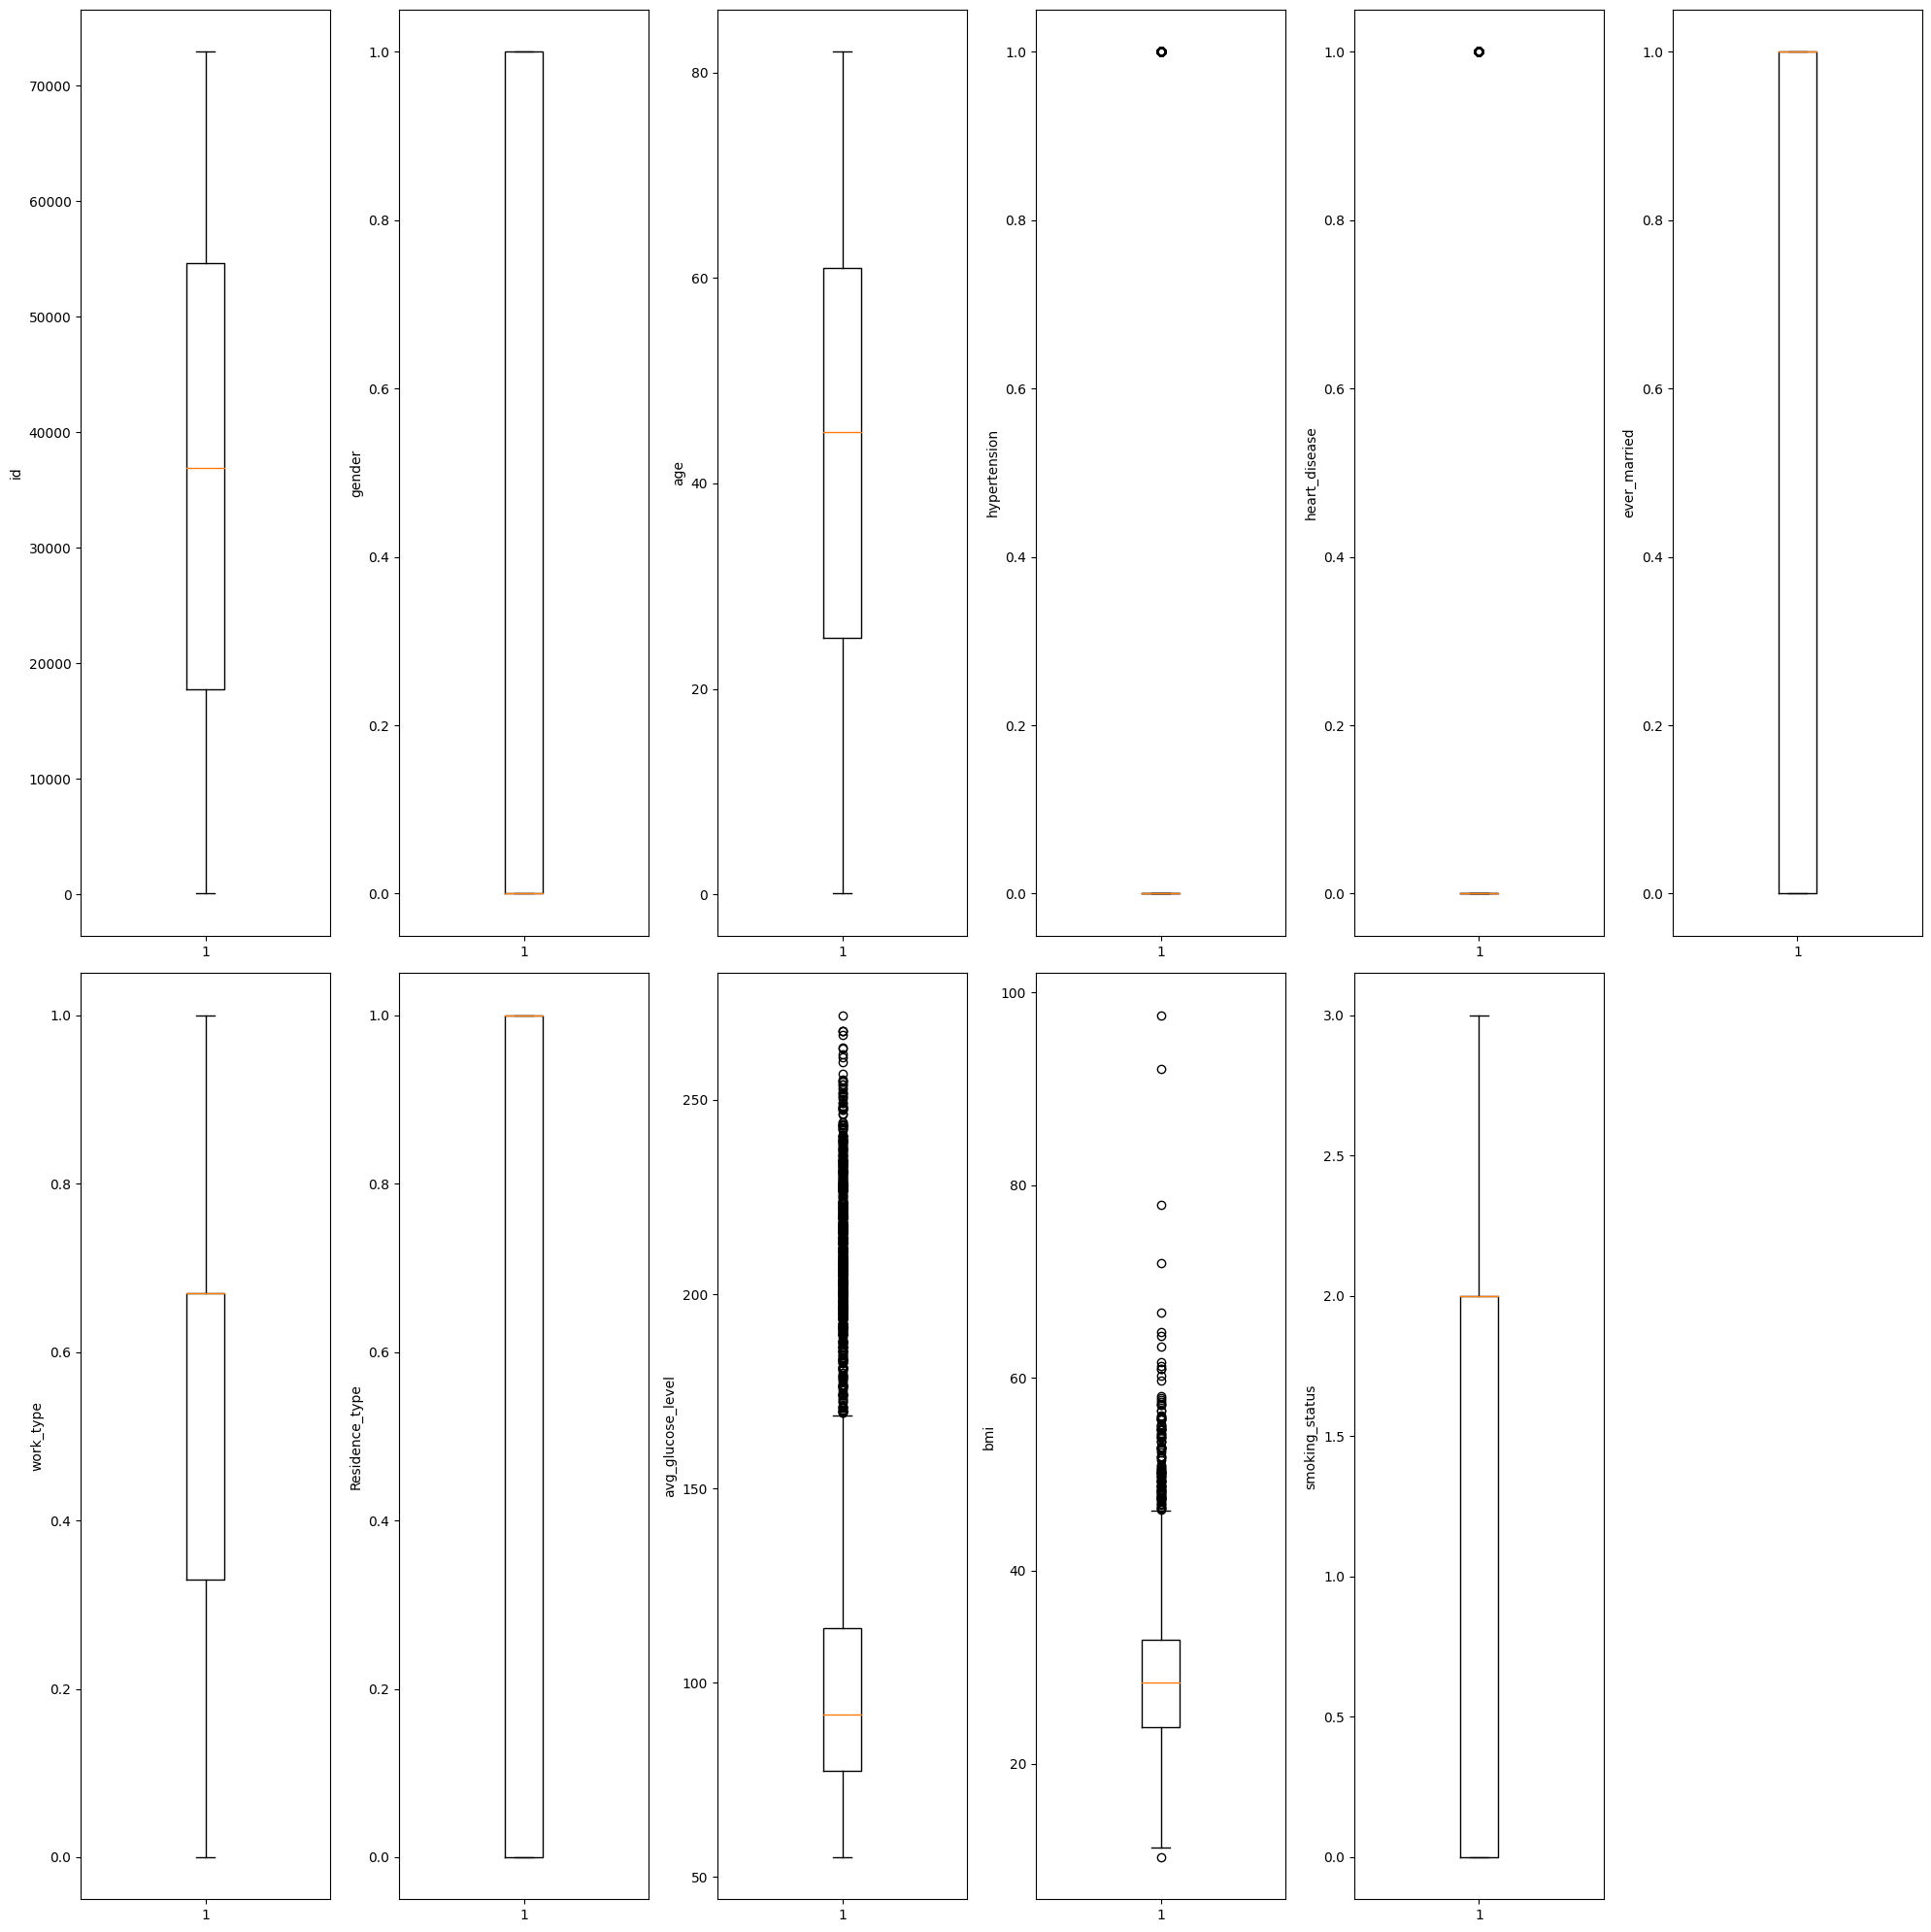

In [12]:
# Check Feature distribution & outliers
plt.figure( figsize=(20,20))
df_copy = df.drop('stroke', axis=1)

le = LabelEncoder()
df_copy = df_copy.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)
df_copy['bmi'].fillna(df_copy['bmi'].mean(), inplace=True)

num_columns = len(df_copy.columns)
rows = num_columns // 6 + (num_columns % 6 > 0)

i = 1
for col in df_copy.columns:
    plt.subplot(rows, 6, i)
    plt.boxplot(df_copy[col]) 
    plt.ylabel(str(col)) 
    i += 1  

plt.tight_layout()
plt.show()


In [13]:
## Target class distribution
target_distribution = df['stroke'].value_counts()

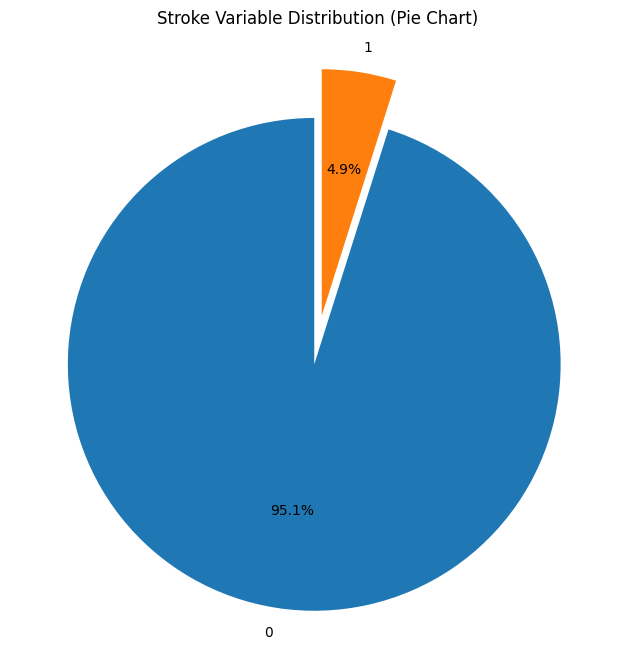

In [14]:
explode = [0.1] * len(target_distribution)   # this defines a margin for each target class
plt.figure(figsize=(8, 8))
target_distribution.plot.pie(autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Stroke Variable Distribution (Pie Chart)')
plt.ylabel('')
plt.show()

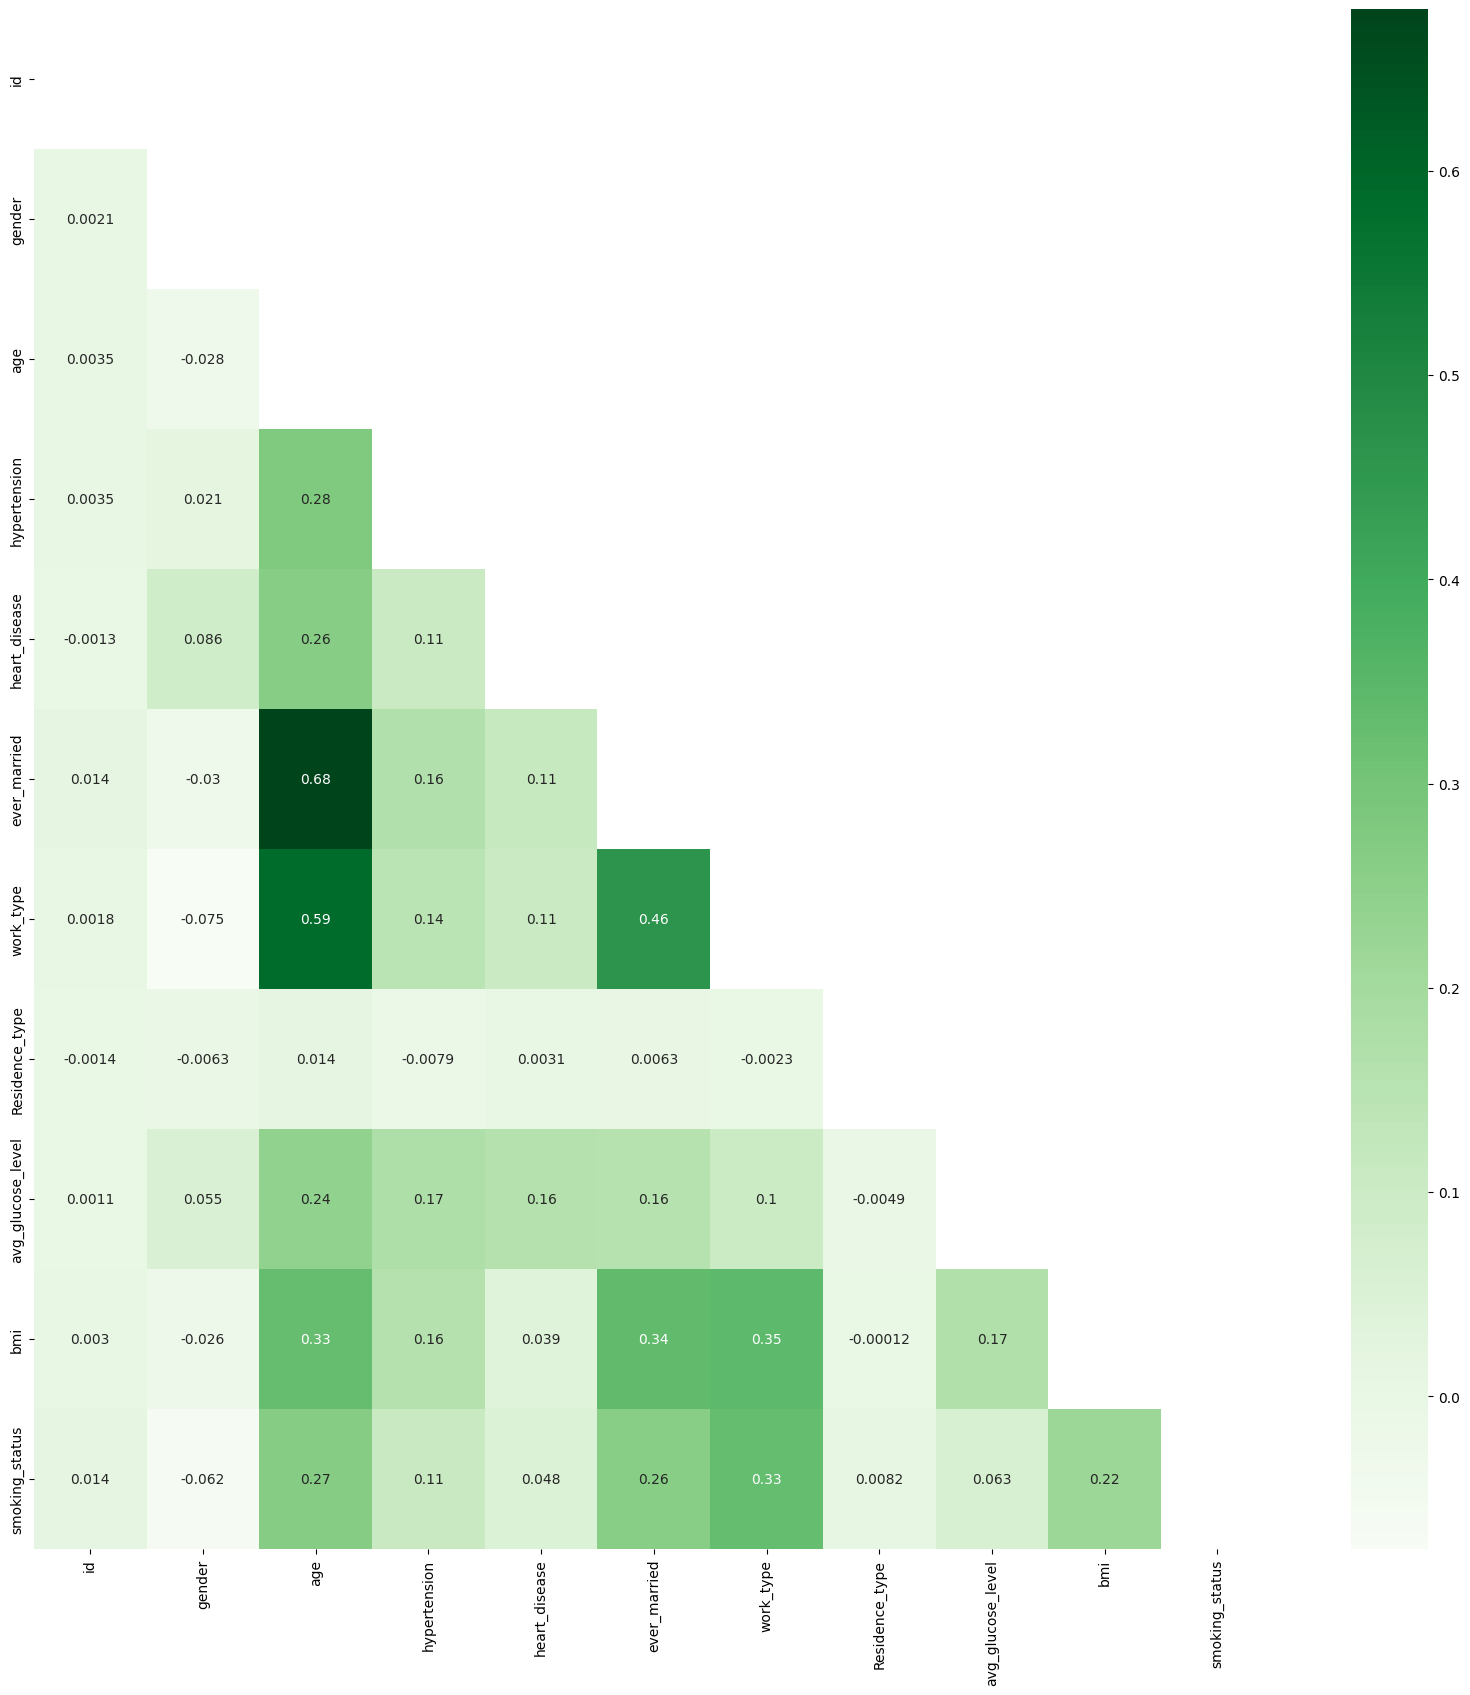

In [15]:
corr_matrix = df_copy.corr(numeric_only=True)
plt.figure( figsize=(20,20))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, annot=True, cmap='Greens', mask=mask)

plt.show()


In [16]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [17]:
df.duplicated().sum().any()

#df = df[df.duplicated(keep=False)]

False

In [18]:
# Fill NaN values

le = LabelEncoder()
df = df.apply(lambda col: le.fit_transform(col) if col.dtype == 'object' else col)
df_copy = df
df_copy['bmi'].fillna(df_copy['bmi'].median(), inplace=True)

In [19]:
df_copy.drop(['id'],axis=1,inplace=True)

In [20]:
## 2_Removing outliers with interquartile range method

for col in df.select_dtypes(include=['number']).columns:
    if col=='stroke':
        break
    IQR = df_copy[col].quantile(0.90) - df_copy[col].quantile(0.10)
    Lower_fence = df_copy[col].quantile(0.10) - (IQR * 3) 
    Upper_fence = df_copy[col].quantile(0.90) + (IQR * 3) 
    
    df_copy = df_copy[(df_copy[col] >= Lower_fence) & (df_copy[col] <= Upper_fence)]

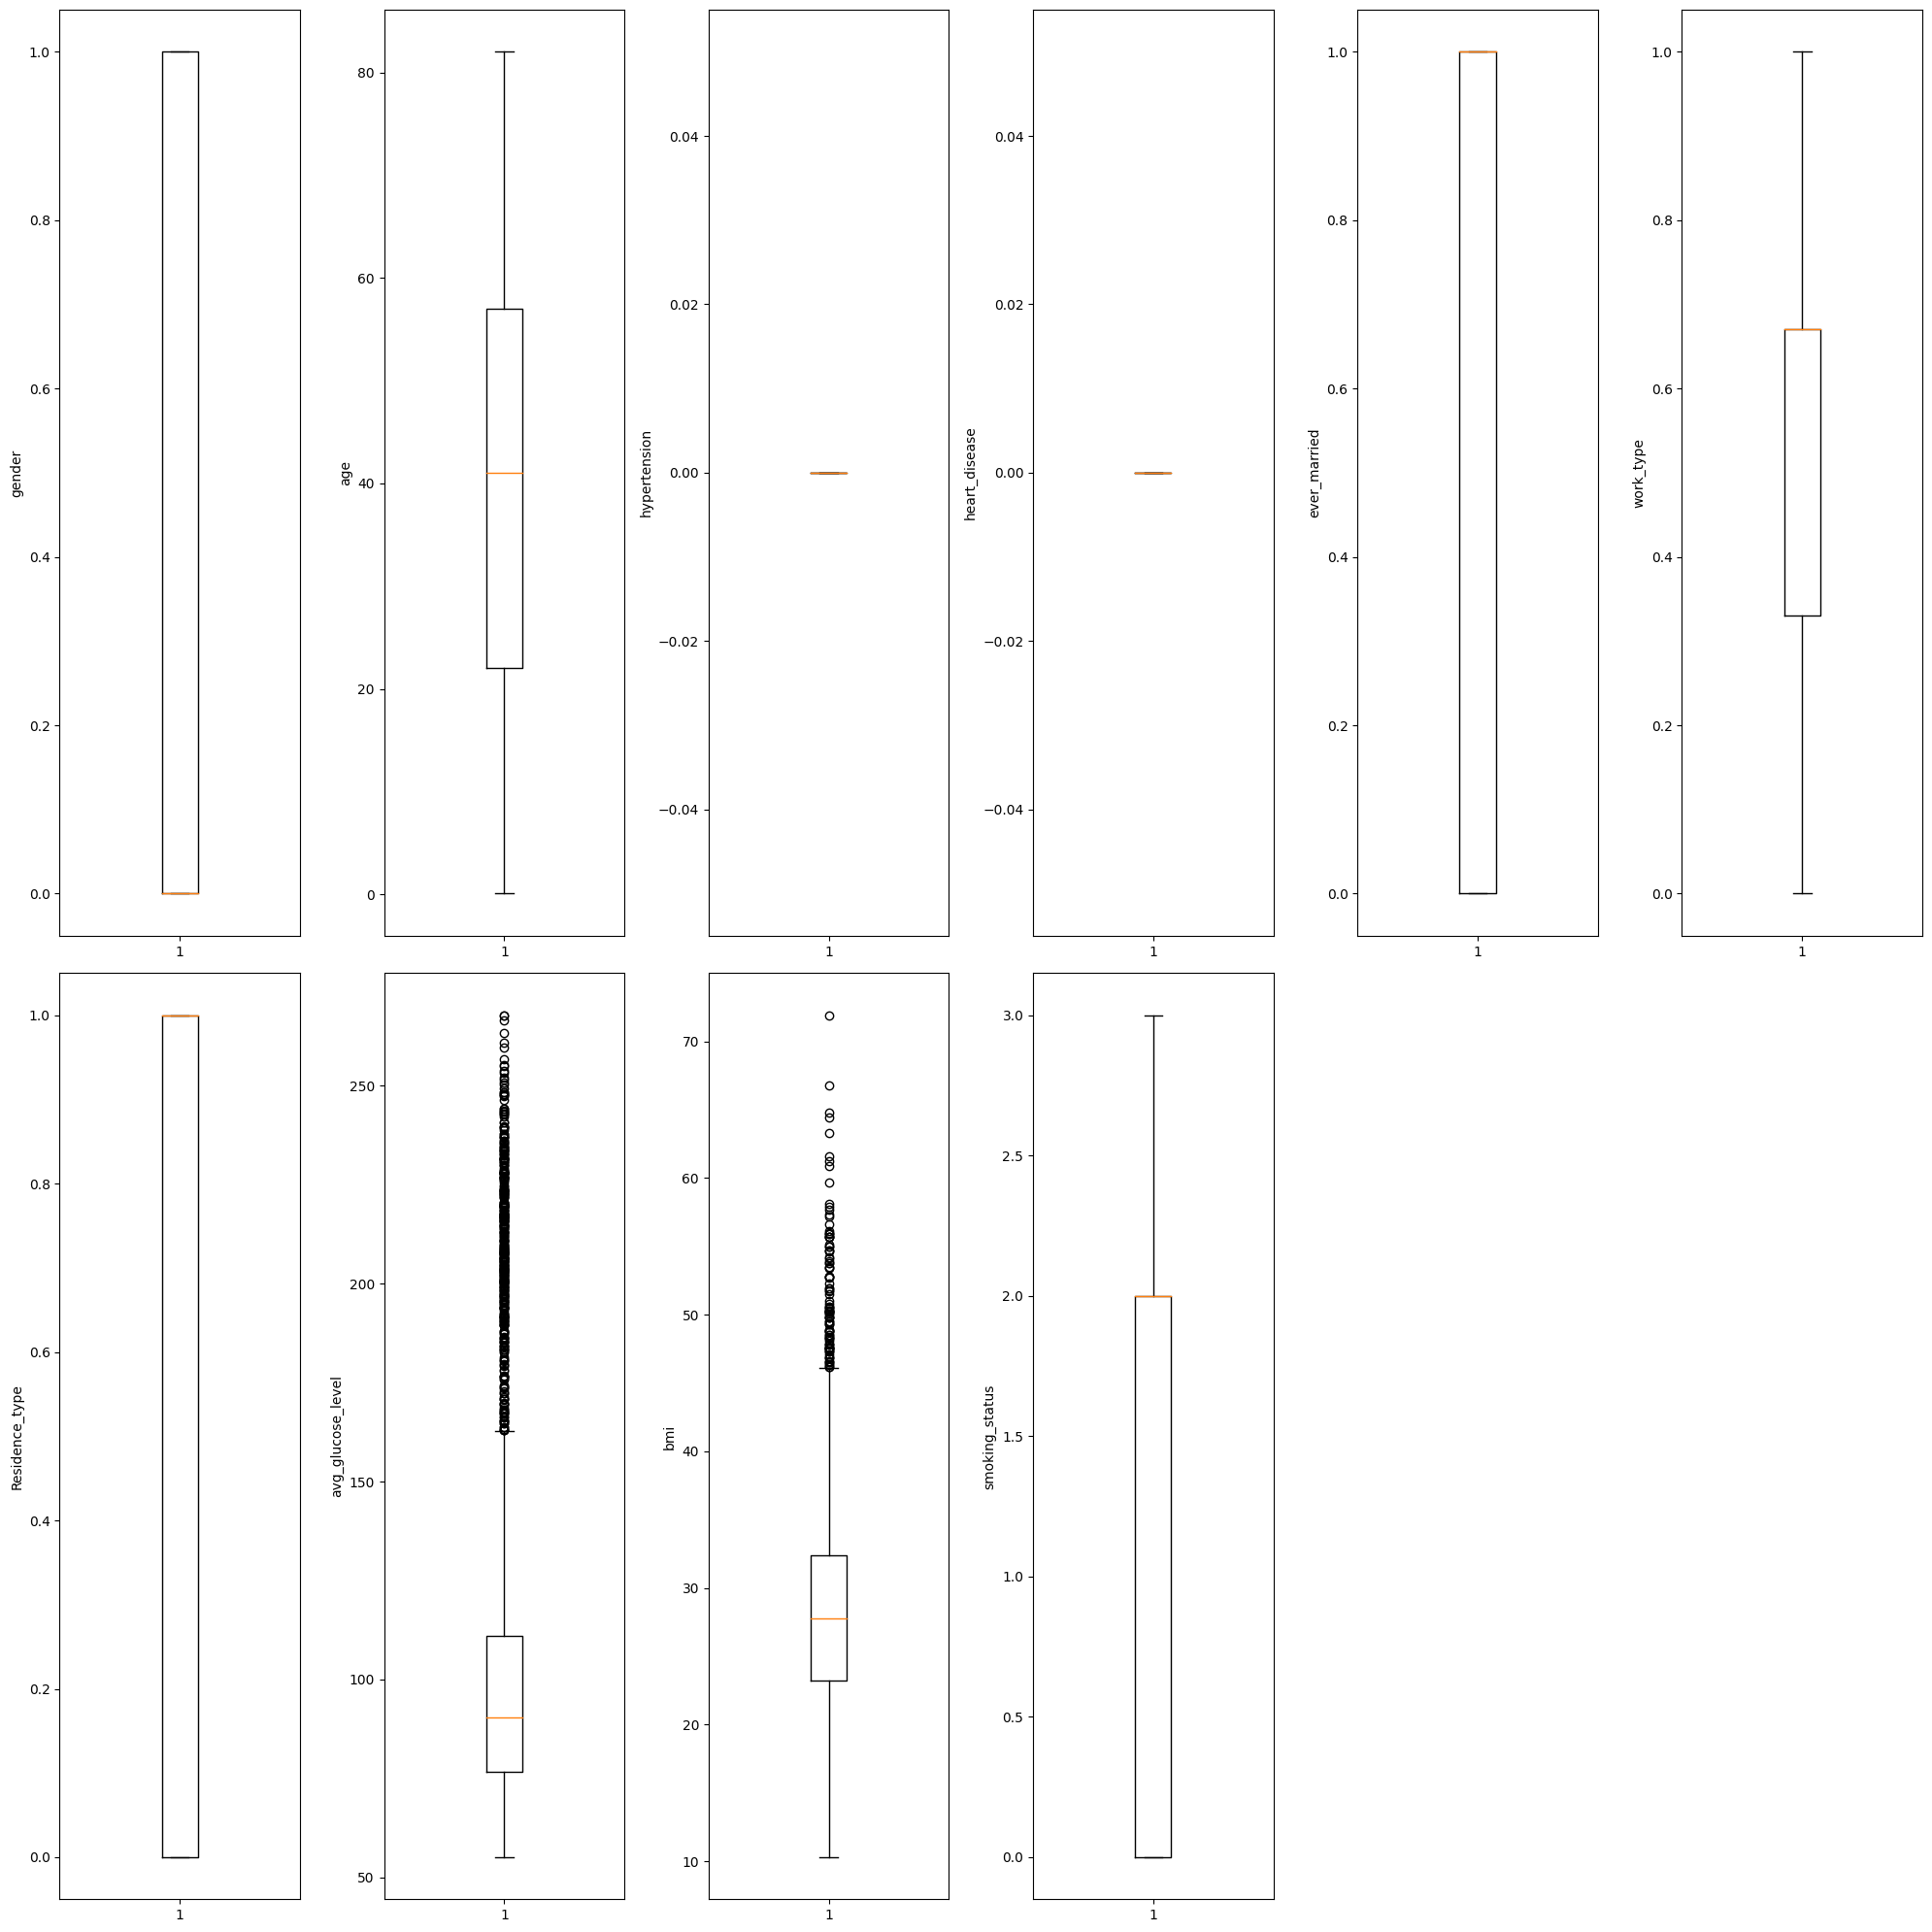

In [21]:
# Check Feature distribution & outliers
plt.figure(figsize=(20, 20))

num_columns = len(df_copy.columns)
rows = num_columns // 6 + (num_columns % 6 > 0)

i = 1
for col in df_copy.columns:
    if col == 'stroke':
        break
    plt.subplot(rows, 6, i)
    plt.boxplot(df_copy[col]) 
    plt.ylabel(str(col)) 
    i += 1  

plt.tight_layout()
plt.show()


In [22]:
df_copy.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [23]:
# more outlier removal from columns [ work_type, avg_glucose_level, bmi]
outlier_columns = ['work_type', 'avg_glucose_level', 'bmi']
for col in outlier_columns:
    
    IQR = df_copy[col].quantile(0.60) - df_copy[col].quantile(0.40)
    Lower_fence = df_copy[col].quantile(0.60) - (IQR * 3) 
    Upper_fence = df_copy[col].quantile(0.40) + (IQR * 3) 
    
    df_copy = df_copy[(df_copy[col] >= Lower_fence) & (df_copy[col] <= Upper_fence)]

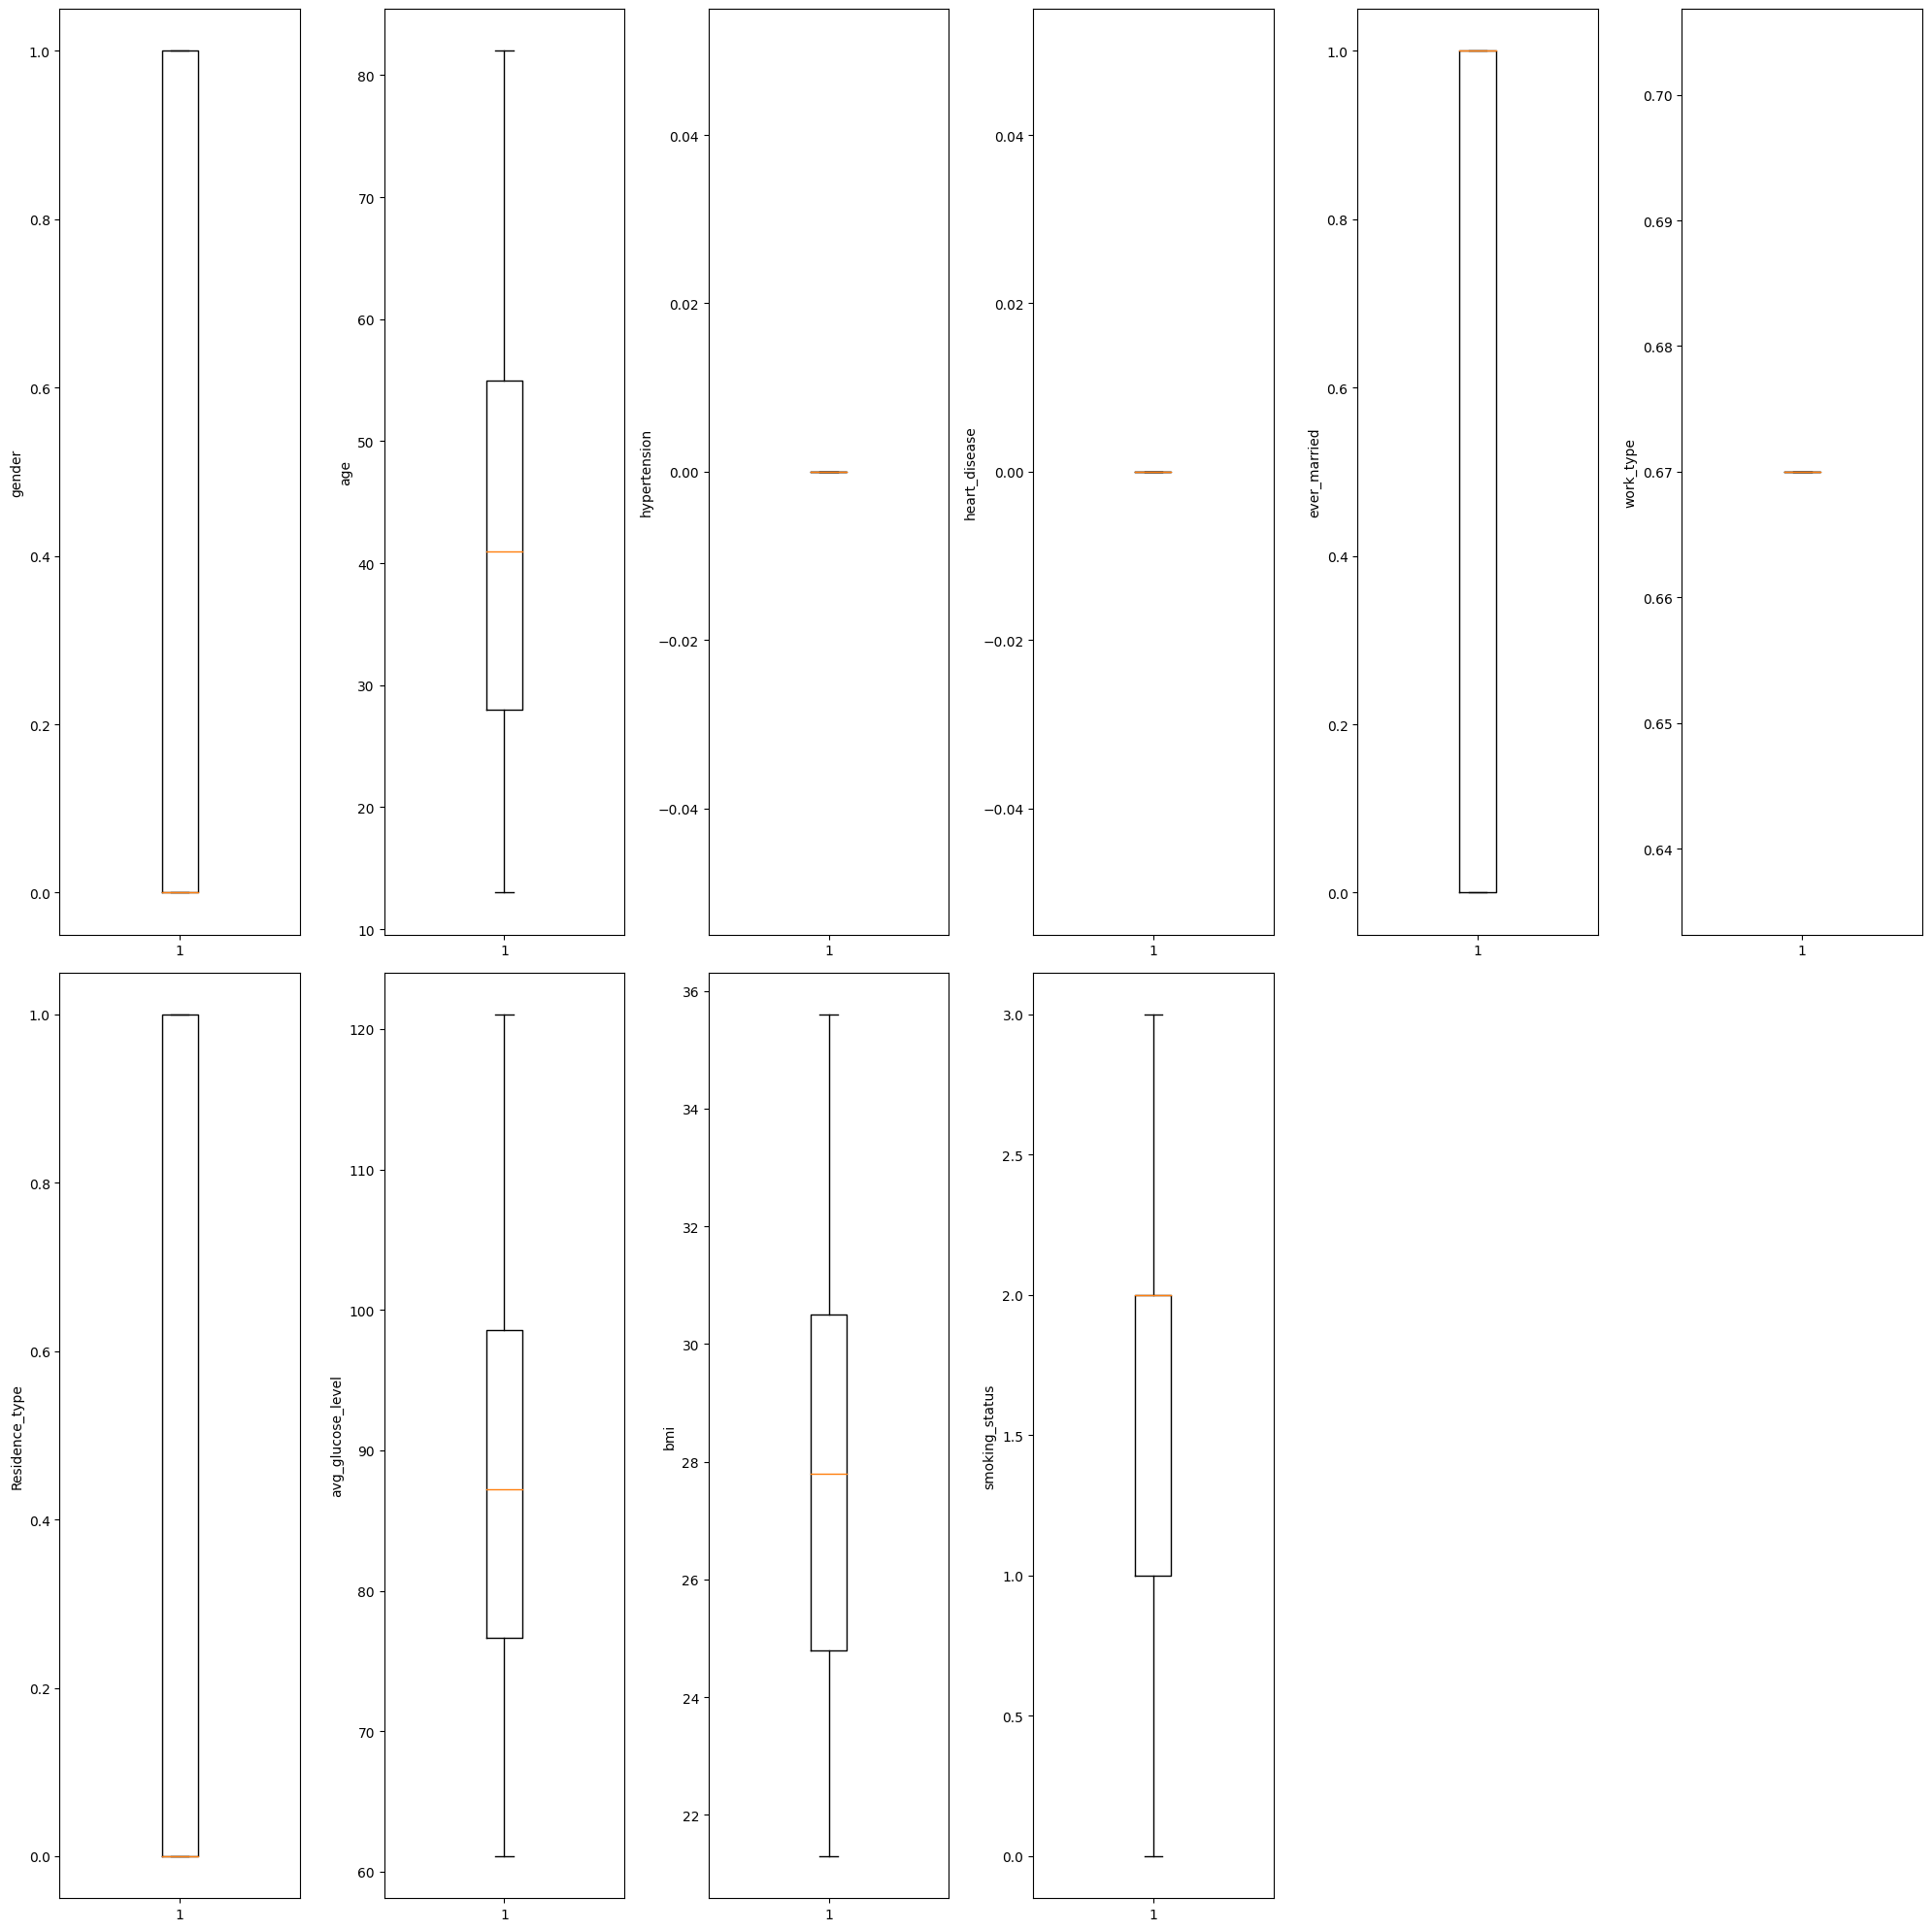

In [24]:
# Check Feature distribution & outliers
plt.figure(figsize=(20, 20))

num_columns = len(df_copy.columns)
rows = num_columns // 6 + (num_columns % 6 > 0)

i = 1
for col in df_copy.columns:
    if col == 'stroke':
        break
    plt.subplot(rows, 6, i)
    plt.boxplot(df_copy[col]) 
    plt.ylabel(str(col)) 
    i += 1  

plt.tight_layout()
plt.show()


In [25]:
X = df_copy.drop('stroke', axis=1)
y = df_copy['stroke']


y_encoded = pd.DataFrame(y, columns = ['stroke'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression()

rfe = RFE(estimator=model)


rfe.fit(X_train_scaled, y_train)


selected_features = X.columns[rfe.support_]


In [27]:
print('original features num: ',len(df.columns))
print('selected features num: ',selected_features.shape[0])

original features num:  11
selected features num:  5


In [28]:
df_rfe = df_copy[selected_features]

In [29]:
df_rfe.columns

Index(['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'], dtype='object')

In [30]:
scaler = StandardScaler()
df_rfe = scaler.fit_transform(df_rfe)
df_rfe = pd.DataFrame(df_rfe, columns=selected_features)


In [31]:
df_rfe.describe()

,gender,age,ever_married,avg_glucose_level,bmi
count,1.457000e+03,1.457000e+03,1.457000e+03,1.457000e+03,1.457000e+03
mean,9.753504e-17,1.560561e-16,1.584944e-16,-3.816058e-16,-1.302093e-15
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-8.190675e-01,-1.671609e+00,-1.462903e+00,-1.821953e+00,-1.762898e+00
25%,-8.190675e-01,-8.210943e-01,-1.462903e+00,-7.753588e-01,-8.099523e-01
50%,-8.190675e-01,-8.398130e-02,6.835722e-01,-6.821841e-02,6.858143e-03
75%,1.220901e+00,7.098327e-01,6.835722e-01,6.967300e-01,7.419876e-01
max,1.220901e+00,2.240760e+00,6.835722e-01,2.206461e+00,2.130565e+00


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_rfe, y, test_size=0.2, random_state=42)

In [33]:
balancing_techniques = {
    'No Resampling': None,
    'SMOTE': SMOTE(random_state=42),
    'Random Over-Sampling': RandomOverSampler(random_state=42),
    'Random Under-Sampling': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Single Models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

# Ensemble Models
ensemble_models = {
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Hyperparameter Grids (Example - Customize for each model)
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {}, # Add an empty dictionary for Naive Bayes since it doesn't usually require hyperparameter tuning
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Bagging': {'n_estimators': [10, 20, 30]},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model Evaluation and Selection
best_models = {}

for name, sampler in balancing_techniques.items():
    print(f"--- {name} ---")
    
    if sampler is not None:
        break
        # Apply the balancing technique
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        print(f"Resampled dataset shape: {Counter(y_resampled)}")
    else:
        # No resampling, use the original dataset
        X_resampled, y_resampled = X_train, y_train

    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

        grid_search.fit(X_resampled, y_resampled)
        y_pred = grid_search.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        best_models[name] = grid_search.best_estimator_
        print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")
        print(f'Test accuracy {test_accuracy}')


    for name, model in ensemble_models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_resampled, y_resampled)
        y_pred = grid_search.predict(X_test)
        best_models[name] = grid_search.best_estimator_
        print(f"{name}: Best Parameters - {grid_search.best_params_}, Best Score - {grid_search.best_score_}")
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f'Test accuracy {test_accuracy}')
        

    # Voting and Stacking (Example - Customize estimators and voting method)
    estimators = [('rf', best_models['Random Forest']), ('xgb', best_models['XGBoost'])]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')  # or 'hard'
    voting_clf.fit(X_resampled, y_resampled)
    best_models['Voting'] = voting_clf

    # Evaluate Best Models on Test Set
    for name, model in best_models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print(f"--- {name} ---")
        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{report}")


--- No Resampling ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression: Best Parameters - {'C': 0.1}, Best Score - 0.9656652360515021
Test accuracy 0.976027397260274
Fitting 5 folds for each of 3 candidates, totalling 15 fits
KNN: Best Parameters - {'n_neighbors': 5}, Best Score - 0.9639484978540771
Test accuracy 0.976027397260274
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Naive Bayes: Best Parameters - {}, Best Score - 0.9630901287553648
Test accuracy 0.976027397260274
Fitting 5 folds for each of 6 candidates, totalling 30 fits
SVM: Best Parameters - {'C': 0.1, 'kernel': 'linear'}, Best Score - 0.9656652360515021
Test accuracy 0.976027397260274
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Decision Tree: Best Parameters - {'max_depth': 5}, Best Score - 0.9545064377682403
Test accuracy 0.958904109589041
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Random Forest: Best Parameters - {'n_estimators': 50}, Best Scor

In [34]:
# Single Models

models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

# Ensemble Models
ensemble_models = {
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

# Hyperparameter Grids (Example - Customize for each model)
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'Naive Bayes': {}, # Add an empty dictionary for Naive Bayes since it doesn't usually require hyperparameter tuning
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [None, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Bagging': {'n_estimators': [10, 20, 30]},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model Evaluation and Selection
best_models = {}

X_resampled, y_resampled = X_train, y_train

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_resampled, y_resampled)
    best_models[name] = grid_search.best_estimator_

for name, model in ensemble_models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_resampled, y_resampled)
    best_models[name] = grid_search.best_estimator_

# Voting and Stacking (Example - Customize estimators and voting method)
estimators = [('rf', best_models['Random Forest']), ('xgb', best_models['XGBoost']),
              ('knn', best_models['KNN']),('logistic', best_models['Logistic Regression'])]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')  # or 'hard'
voting_clf.fit(X_resampled, y_resampled)
best_models['Voting'] = voting_clf
one_dict = {}
# Evaluate Best Models on Test Set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f'\n{name}\n')
    one_dict[name] = report['1']
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Logistic Regression

--- Logistic Regression ---
Accuracy: 0.976027397260274
Classification Report:
{'0': {'precision': 0.976027397260274, 'recall': 1.0, 'f1-score': 0.9878682842287695, 'support': 285}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}, 'accuracy': 0.976027397260274, 'macro avg': {'precision': 0.488013

In [35]:
one_dict = dict(sorted(one_dict.items(), key=lambda item: item[1]['f1-score'], reverse=True))
for model,values in one_dict.items():
    print(f'{model} : {values}')

AdaBoost : {'precision': 0.5, 'recall': 0.14285714285714285, 'f1-score': 0.22222222222222224, 'support': 7}
Gradient Boosting : {'precision': 0.3333333333333333, 'recall': 0.14285714285714285, 'f1-score': 0.2, 'support': 7}
Decision Tree : {'precision': 0.14285714285714285, 'recall': 0.14285714285714285, 'f1-score': 0.14285714285714285, 'support': 7}
Logistic Regression : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
KNN : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
Naive Bayes : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
SVM : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
Random Forest : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
Extra Trees : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
Bagging : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
XGBoost : {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7}
Voting : {'precision': 0.0, '

In [36]:
Counter(y_test)

Counter({0: 285, 1: 7})

In [37]:
Counter(df['stroke'])

Counter({0: 4861, 1: 249})

In [38]:
Counter(y_train)

Counter({0: 1125, 1: 40})